#### Propensity Score Matching

In [1]:
#!pip install causalinference

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from causalinference import CausalModel
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [3]:
df = pd.read_csv("data.csv")
df = df.drop(columns=['interior_color', 'exterior_color' , 'city' , 'trim_name' , 'sp_name'])

In [4]:
df['price'] = np.power(10, df['log10_price'])
df.drop(columns=['log10_price'], inplace=True)

In [5]:
unique_engine_types = df['engine_type'].unique()
unique_engine_types

array(['I4', 'H4', 'V6', 'I6', 'V6 Diesel', 'Missing', 'V8',
       'V8 Biodiesel', 'V8 Flex Fuel Vehicle', 'V6 Flex Fuel Vehicle',
       'I4 Hybrid', 'V6 Hybrid', 'I3', 'I5', 'I4 Flex Fuel Vehicle',
       'I4 Diesel', 'I6 Diesel', 'V8 Diesel', 'R2', 'W12', 'V10', 'V12',
       'V6 Biodiesel', 'H6', 'I2', 'W12 Flex Fuel Vehicle',
       'I5 Biodiesel', 'V8 Hybrid', 'H4 Hybrid',
       'V8 Compressed Natural Gas'], dtype=object)

In [6]:
# Define the engine types for hybrid vehicles
hybrid_types = [
    'V6 Hybrid', 
    'I4 Hybrid', 
    'H4 Hybrid', 
    'V8 Hybrid'
]

# Set a flag indicating whether each vehicle is a hybrid (1) or not (0)
df['is_hybrid'] = df['engine_type'].apply(lambda x: 1 if x in hybrid_types else 0)

In [7]:
#hybrid_types = ['V6 Diesel', 'I4 Diesel', 'I6 Diesel', 'V8 Diesel', 'V8 Flex Fuel Vehicle', 'V6 Flex Fuel Vehicle', 'W12 Flex Fuel Vehicle', 'I4 Flex Fuel Vehicle']
#hybrid_types = ['V8 Biodiesel', 'V6 Biodiesel', 'I5 Biodiesel']
#hybrid_types = ['V8 Flex Fuel Vehicle', 'V6 Flex Fuel Vehicle', 'W12 Flex Fuel Vehicle', 'I4 Flex Fuel Vehicle']

In [8]:
df.head()

,daysonmarket,savings_amount,seller_rating,back_legroom,body_type,engine_type,fleet,frame_damaged,franchise_make,front_legroom,...,transmission_display,wheel_system,wheelbase,width,fuel_economy,mileage,dealer_location,engine_power,price,is_hybrid
0,522.0,0.0,2.80000,35.1,SUV / Crossover,I4,999,999,Jeep,41.2,...,9-Speed Automatic Overdrive,FWD,101.2,79.6,1.743673,1.640997,-2.537647,-1.255073,23141.0,0
1,207.0,0.0,3.00000,38.1,SUV / Crossover,I4,999,999,Land Rover,39.1,...,9-Speed Automatic Overdrive,AWD,107.9,85.6,1.040489,0.931417,-2.996780,-0.557086,46500.0,0
2,1233.0,0.0,1.64467,35.4,Sedan,H4,0,0,FIAT,43.3,...,6-Speed Manual,AWD,104.3,78.9,-2.962612,2.473994,-1.956206,-0.505334,46995.0,0
3,196.0,0.0,3.00000,37.6,SUV / Crossover,V6,999,999,Land Rover,39.0,...,8-Speed Automatic Overdrive,AWD,115.0,87.4,-0.515961,0.271485,-3.387703,0.300200,67430.0,0
4,137.0,0.0,3.00000,38.1,SUV / Crossover,I4,999,999,Land Rover,39.1,...,9-Speed Automatic Overdrive,AWD,107.9,85.6,1.139372,0.827917,-3.061594,-0.560325,48880.0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   daysonmarket          100000 non-null  float64
 1   savings_amount        100000 non-null  float64
 2   seller_rating         100000 non-null  float64
 3   back_legroom          100000 non-null  float64
 4   body_type             100000 non-null  object 
 5   engine_type           100000 non-null  object 
 6   fleet                 100000 non-null  int64  
 7   frame_damaged         100000 non-null  int64  
 8   franchise_make        100000 non-null  object 
 9   front_legroom         100000 non-null  float64
 10  fuel_tank_volume      100000 non-null  float64
 11  fuel_type             100000 non-null  object 
 12  has_accidents         100000 non-null  int64  
 13  height                100000 non-null  float64
 14  isCab                 100000 non-null  int64  
 15  l

In [10]:
# Specify the names of categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(['price', 'is_hybrid'])

# Create a ColumnTransformer for encoding categorical variables and scaling numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ]
)

# Create a pipeline
pipeline = make_pipeline(
    preprocessor,
    LogisticRegression()
)

# Define features and target variable
X = df.drop(columns=['price', 'is_hybrid'])
y = df['is_hybrid']

# Train the model using the pipeline
pipeline.fit(X, y)

# Calculate propensity scores
df['propensity_score'] = pipeline.predict_proba(X)[:, 1]

In [11]:
# Initialize the CausalModel
causal = CausalModel(
    Y=df['price'].values, 
    D=df['is_hybrid'].values, 
    X=df['propensity_score'].values
)

# Perform matching
causal.est_via_matching()

# Display the results
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE -24881.877  12082.623     -2.059      0.039 -48563.818  -1199.937
           ATC -25049.739  12303.722     -2.036      0.042 -49165.035   -934.443
           ATT -15971.235  21042.825     -0.759      0.448 -57215.172  25272.702



The results indicate that being a hybrid vehicle (HV) has a statistically significant negative impact on price (average price difference = $25,000). However, based on the results from the EBM analysis, it is understood that in the US market, vehicles with conflicting characteristics of high fuel efficiency and high engine power are advantageous. Typically, both HV and EV (Electric Vehicles) would meet these conditions, but given the period of data collection, only HVs were considered, leading to the observed negative impact. It is hypothesized that while HVs show a negative impact on the market overall, there might be a strong premium on specific brands.

In [12]:
# Column name storing the brand names
brand_col = 'make_name'

# Loop through each brand
for brand in df[brand_col].unique():
    # Extract data for the current brand
    df_brand = df[df[brand_col] == brand].copy()
    
    # Check if both hybrid and non-hybrid vehicles exist
    if df_brand['is_hybrid'].nunique() < 2:
        continue  # Skip if both classes do not exist
    
    # Specify the names of categorical and numerical columns
    # Exclude the brand name column
    categorical_cols = df_brand.select_dtypes(include=['object']).columns.drop([brand_col])
    numeric_cols = df_brand.select_dtypes(include=['int64', 'float64']).columns.drop(['price', 'is_hybrid'])
    
    # Create a ColumnTransformer for encoding categorical variables and scaling numerical variables
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_cols),
            ('cat', OneHotEncoder(), categorical_cols)
        ]
    )
    
    # Create a pipeline
    pipeline = make_pipeline(
        preprocessor,
        LogisticRegression()
    )
    
    # Define features and target variable
    # Exclude the brand name column as well
    X = df_brand.drop(columns=['price', 'is_hybrid', brand_col])
    y = df_brand['is_hybrid']
    
    # Train the model using the pipeline
    pipeline.fit(X, y)
    
    # Calculate propensity scores
    df.loc[df[brand_col] == brand, 'propensity_score'] = pipeline.predict_proba(X)[:, 1]

In [13]:
# Column name storing the brand names
brand_col = 'make_name'

# Loop through each brand
for brand in df[brand_col].unique():
    # Extract data for the current brand
    df_brand = df[df[brand_col] == brand].copy()
    
    # Check if both hybrid and non-hybrid vehicles exist
    if df_brand['is_hybrid'].nunique() < 2:
        continue  # Skip if both classes do not exist
    
    # Check if propensity scores are calculated and not null
    if 'propensity_score' not in df_brand.columns or df_brand['propensity_score'].isnull().any():
        print(f"Skipping {brand} due to missing propensity scores.")
        continue
    
    try:
        # Initialize the CausalModel
        causal = CausalModel(
            Y=df_brand['price'].values, 
            D=df_brand['is_hybrid'].values, 
            X=df_brand[['propensity_score']].values
        )
        
        # Perform matching
        causal.est_via_matching()
        
        # Display the results
        print(f"Brand: {brand}")
        print(causal.estimates)
        print("\n")
    except ValueError as e:
        print(f"Skipping {brand} due to an error: {e}")
        continue

Brand: Subaru

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE -11136.403   2090.687     -5.327      0.000 -15234.149  -7038.657
           ATC -11167.406   2093.186     -5.335      0.000 -15270.051  -7064.760
           ATT   9096.200   9202.850      0.988      0.323  -8941.385  27133.785



Brand: Hyundai

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE -14435.804   7378.419     -1.956      0.050 -28897.506     25.897
           ATC -14330.096   7512.241     -1.908      0.056 -29054.090    393.897
           ATT -20107.151   9369.626     -2.146      0.032 -38471.618  -1742.684



Brand: Chevrolet

Treatment Effect Estimates: Matching

                     

Looking at the scores by brand, it was found that there is a hybrid vehicle (HV) premium for the brands Acura, Toyota, Ford, and Kia. Considering the period of data collection, it cannot be asserted with statistical significance due to the small number of data on HVs. However, as a general trend, it can be considered that there is an HV premium in the US market for these four brands. This means that choosing HVs from these four brands when purchasing a new car could result in a higher resale value.

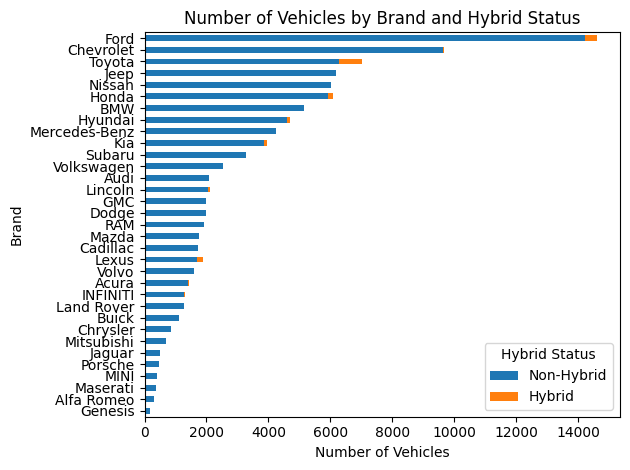

In [14]:
# Aggregate the data based on 'make_name' and 'is_hybrid', counting the number of records for each
brand_hybrid_counts = df.groupby(['make_name', 'is_hybrid']).size().unstack(fill_value=0)

# Filter out brands with a total count of less than 100 vehicles
brand_hybrid_counts = brand_hybrid_counts[brand_hybrid_counts.sum(axis=1) >= 100]

# Sort the brands by the total number of vehicles in ascending order
# This will result in the brands with the most vehicles being at the bottom of the chart,
# which is the top when displayed as a horizontal bar chart
brand_hybrid_counts = brand_hybrid_counts.sort_values(by=[0, 1], ascending=True)

# Display the horizontal bar chart
brand_hybrid_counts.plot(kind='barh', stacked=True, color=['#1f77b4', '#ff7f0e'])

plt.title('Number of Vehicles by Brand and Hybrid Status')
plt.xlabel('Number of Vehicles')
plt.ylabel('Brand')
plt.legend(['Non-Hybrid', 'Hybrid'], title='Hybrid Status')
plt.tight_layout()

plt.show()